# Social systems over time

Today we are going to examine a social network and how it changes over time. As a dataset we will use the Enron e-mail corpus, which has been analyzed in a number of academic papers. For ease of use, we will be using the Enron dataset that is packaged through [Kaggle Datasets](https://www.kaggle.com/wcukierski/enron-email-dataset). 

This file is a csv with only two columns, `file` and `message`.  The `file` field is the username of the Outlook mailbox and `message` has a single e-mail message.

This file is 1.3 GB so the `pandas` package is not a good way to process this file unless you are on a well spec'ed machine. 

Instead you should use the `csv` package to parse this file and reduce it to a dataset that we can hold in memory and build networks from.

This parsing code does **not** need to be perfect, we just want to get going. We will evaluate our data losses post-parsing.

In [1]:
#Exercise


In [2]:
#Answer
import sys
import csv
import pandas as pd
csv.field_size_limit(sys.maxsize)

#full dataset to capture
fullset = []

#load up the file with csv
cfile = csv.reader(open('../data/enron_emails.csv'))
#Go through each row to get the data
for row in cfile:
    rowdata = {}
    for line in row[1].split('\n'):
        #Pull the data
        if ': ' in line:
            sline = line.split(': ')
            rowdata[sline[0]] = sline[1]
    #Expand/create the date rows
    try:
        dow = rowdata['Date'].split(', ')[0]
        sdate = ' '.join( rowdata['Date'].split(' ')[1:4] )
        if ',' in rowdata['To']:
            for name in rowdata['To'].split(', '):
                fullset.append([rowdata['From'], name, dow, sdate])
        else:
            fullset.append([rowdata['From'], rowdata['To'], dow, sdate])
    except KeyError:
        #I will pass, but in real research the line index should be logged
        #for further checking
        pass
#Put it into a dataframe to ease further searching
df = pd.DataFrame(fullset, columns = ['from', 'to', 'dow', 'strdate'])

Now that we have a dataframe, let's evaluate our losses. How should we do that easily?

In [3]:
#Exercise


In [4]:
#Answer
print('full', len(df))

print('restricted', len( df[df.dow.isin(['Mon', 'Fri', 'Wed', 'Thu', 'Tue', 'Sun', 'Sat'])]) )

full 866624
restricted 857667


With my quick and dirty approach I lost approximately 4k records (so one percent). This is a pretty acceptable loss for our exercise.

Since this class is about preparation for independent research, we will not jump straight to our analysis topic. 

Good research is about building an understanding of the dataset. One of the best ways to do that is to understand the degree of individuals.

An unweighted, undirected network should be sufficient to gain an intuition of the system

In [5]:
#Exercise


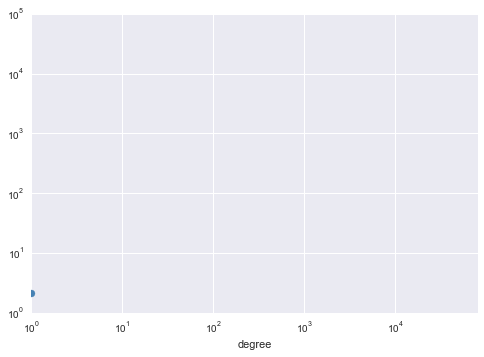

In [12]:
#Answer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#Answer
#Strip out whitespace
df['from'] = df['from'].apply(lambda x: x.lstrip().strip())
df['to'] = df['to'].apply(lambda x: x.lstrip().strip())
#Do the groupbys on from and to individually and explicitly for clarity
#From
fdf = df.groupby('from').agg(len)
fnames, fcounts = fdf.index.values, fdf['to'].values
#To
tdf = df.groupby('to').agg(len)
tnames, tcounts = tdf.index.values, tdf['from'].values
#Aggregate the from and to in the degree dict
degree_dict = {}
for nset, cset in [[fnames, fcounts], [tnames, tcounts]]:
    for n, c in zip(nset, cset):
        if n not in degree_dict:
            degree_dict[n] = c
        else:
            degree_dict[n] += c
#Plot this out, I want to use a scatter so I use the hist function to generate the histogram
import numpy as np
n, bins, patches = plt.hist(list(degree_dict.values()), log=True, bins=np.logspace(0, 5, 100), normed=True);
#then clear the plot 
plt.clf();
#Then plot the bins and values using the scatter function
plt.scatter(bins[:-1], n, color='steelblue')
plt.loglog()
plt.ylim(1, 100000)
plt.xlim(0, 80000)
plt.xlabel('degree')

Now that we have a baseline for the entire system, now we can start making comparisons at a systems level.

Let's start with just restricting and comparing the yearly amounts of data.

In [13]:
#Exercise


2000 22160
2001 52657
2002 11925


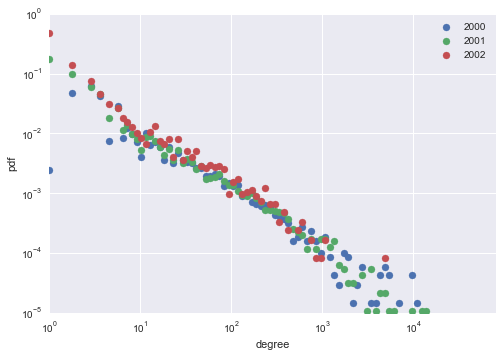

In [14]:
#Answer
#First we need to clean the strdate
def strdate_cleaner(strdate):
    from datetime import datetime
    try:
        return datetime.strptime(strdate, '%d %b %Y') 
    except ValueError:
        return np.nan
    
df['date'] = df.strdate.apply(strdate_cleaner)
#Now we need to rectrict this
df.dropna(inplace=True)
df = df[(df['from'] != '') & (df['to'] != '')]
#Get teh weeks/days/years
df['week_num'] = df.date.apply(lambda x: x.isocalendar()[1])
df['month'] = df.date.apply(lambda x: x.month)
df['year'] = df.date.apply(lambda x: x.year)
#restrict year
df = df[(df.year >= 2000) & (df.year <= 2002)]

#And now we can easily aggregate, we just need to write a function that will return the degree distribution
def aggregate_degree(df):
    #From
    fdf = df.groupby('from').agg(len)
    fnames, fcounts = fdf.index.values, fdf['to'].values
    #To
    tdf = df.groupby('to').agg(len)
    tnames, tcounts = tdf.index.values, tdf['from'].values
    #Aggregate the from and to in the degree dict
    degree_dict = {}
    for nset, cset in [[fnames, fcounts], [tnames, tcounts]]:
        for n, c in zip(nset, cset):
            if n not in degree_dict:
                degree_dict[n] = c
            else:
                degree_dict[n] += c
    return degree_dict

#I'll start with doing this by year
ygdf = df.groupby('year')
year_dataset = {}
year_degreesets = {}
for year in ygdf.groups.keys():
    tdegree = aggregate_degree(ygdf.get_group(year))
    year_degreesets[year] = tdegree
    print(year, len(tdegree.keys()) )
    year_dataset[year] = np.histogram(list(tdegree.values()), normed=True, bins = np.logspace(0, 5, 100))
#Plot the years
for year, (y, x) in sorted(year_dataset.items()):
    plt.scatter(x[:-1], y, label=str(year))
plt.loglog()
plt.ylim(0.00001, 1)
plt.xlim(1, 80000)
plt.legend()
plt.xlabel('degree')
plt.ylabel('pdf')

Now let's examine the change in an individual user's degree over time.

In [15]:
#Exercise


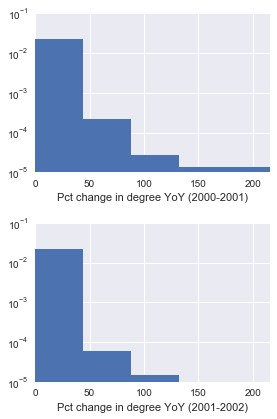

In [16]:
#Answer
#Restrict the users
userset = []
for year in year_degreesets:
    userset += list(year_degreesets[year].keys())
userset = list(set(userset))

#Get the differences
diff2000, diff2001 = [], []
for (ty, tempvar) in [(2000, diff2000), (2001, diff2001)]:
    for u in userset:
        if u in year_degreesets[ty] and u in year_degreesets[ty+1]:
            tempvar.append( (year_degreesets[ty+1][u] - year_degreesets[ty][u]) / year_degreesets[ty][u] )

xmax = max([max(diff2000), max(diff2001)])                     
#Now plot it out
fig = plt.figure(figsize = (4, 6))
#2000 to 2001
ax1 = fig.add_subplot(211)
ax1.hist(diff2000, bins=np.linspace(0, xmax, 50), normed=True, log=True)
ax1.set_ylim(0.00001, .1)
ax1.set_xlim(0, xmax/10)
ax1.set_xlabel('Pct change in degree YoY (2000-2001)')
#2001 to 2002
ax2 = fig.add_subplot(212)
ax2.hist(diff2001, bins=np.linspace(0, xmax, 50), normed=True, log=True)
ax2.set_ylim(0.00001, .1)
ax2.set_xlim(0, xmax/10)
ax2.set_xlabel('Pct change in degree YoY (2001-2002)')
plt.tight_layout()


And we can also statistically test to see if these distributions are different

In [21]:
from scipy import stats

stats.ks_2samp(diff2000, diff2001)

Ks_2sampResult(statistic=0.19885055772964882, pvalue=2.2688055265052399e-91)

A technosocial system, such as e-mail during a period like 2000-2002 is likely to see a dramatic per-user change year over year (as the technology is on a dramatic increase in the utilization across the firm).

This is decidedly different from a system that has reached mass adoption. 

-> How many friends did you add on Facebook in 2017? In 2012? Likely very different.

**But has the network itself changed?**

In [22]:
#Exercise


In [23]:
#Answer
import networkx as nx

def construct_network(tdf):
    G = nx.Graph()
    G.add_edges_from( tdf.loc[:, ['from', 'to']].values.tolist() )
    return max(nx.connected_component_subgraphs(G), key=len)

yearset = [2000, 2001, 2002]
year_networks ={}
for year in yearset:
    year_networks[year] = construct_network(df[df.year == year])

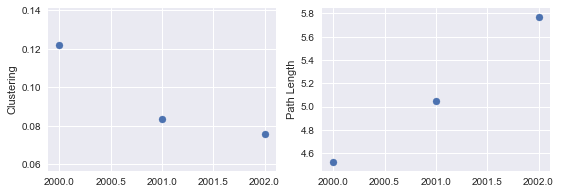

In [25]:
#Answer
import os, json
if os.path.exists('../data/enron_year_connectivity.json') == False:
    clustering, paths, degrees = [], [], []
    for year in yearset:
        clustering.append( nx.average_clustering(year_networks[year]) )
        paths.append( nx.average_shortest_path_length(year_networks[year]) )
    #Save it all for the students
    json.dump({'clustering': clustering, 'paths': paths}, \
              open('../data/enron_year_connectivity.json', 'w'))
else:
    data_dict = json.load(open('../data/enron_year_connectivity.json'))
    clustering = data_dict['clustering']
    paths = data_dict['paths']
#Plot it out
fig = plt.figure(figsize = (9, 3))
ax = fig.add_subplot(121)
ax.scatter(yearset, clustering)
ax.set_ylabel('Clustering')
#path length
ax = fig.add_subplot(122)
ax.scatter(yearset, paths)
ax.set_ylabel('Path Length')

**TE** What is your explanation for this observed behavior?

Now examine month to month behavior in 2001

In [ ]:
#Exercise


1
2
3
4
5
6
7
8
9
10
11
12


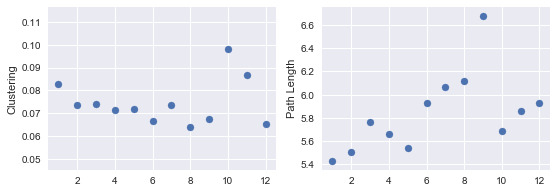

In [36]:
#Answer
if os.path.exists('../data/enron_month_connectivity.json') == False:
    #Create the networks
    monthset = [x+1 for x in range(12)]
    month_networks ={}
    for month in monthset:
        month_networks[month] = construct_network(df[(df.year == 2001) & (df.month == month)])
    #Cluster it up
    clustering, paths = [], []
    for month in monthset:
        clustering.append( nx.average_clustering(month_networks[month]) )
        paths.append( nx.average_shortest_path_length(month_networks[month]) )
    #Save it all for the students
    json.dump({'clustering': clustering, 'paths': paths}, \
              open('../data/enron_month_connectivity.json', 'w'))
else:
    data_dict = json.load(open('../data/enron_month_connectivity.json'))
    clustering = data_dict['clustering']
    paths = data_dict['paths']
#Plot it out
fig = plt.figure(figsize = (9, 3))
ax = fig.add_subplot(121)
ax.scatter(monthset, clustering)
ax.set_ylabel('Clustering')
#path length
ax = fig.add_subplot(122)
ax.scatter(monthset, paths)
ax.set_ylabel('Path Length')

# So how do we study a social network over time? 

The major concern with studying a network over a time period, is that the behavior that you observe is an artifact of the time window that has been chosen. 

**Why?** Let's think through this. Assume that each agent $A$ has a behavioral pattern that is drawn from some distribution $B$. On any given day, the agent $A$ draws an action from distribution $B$ and after some period, say 3 weeks, the user will have, effectively, drawn a full set of behaviors from distribution $B$.

If you were to sample the network at 1-week intervals, then it is impossible to have observed that user's complete behavior pattern. Since you do not know what, if anything, influenced the draws from $B$ then given one week's worth of data you will not be able to properly estimate the distribution.

Since we are interested in properly characterizing agent behavior, thie means that your time window should be significantly larger (how much larger, we'll get to that) than the typical time-scale of the phenomena under study. 

## 1. Your question imposes time and the change in behavior is the quantity of interest

If you ask a question, such as "How did the facebook graph change 6 months after X? one year after X?" then you find yourself in a relatively easy analytical situation since the question itself has imposed the timescale. 

Major issue - you can answer your question, but given how arbitrary the choice is the analysis will lack generalizability to other contexts. In this example, it is unclear why the change in the facebook network will be the same as the Twitter network. 

## 2. Some event has occurred that marks the shift in time (i.e. natural experiment like)

There is an exogenous shock to the system, you then study the network pre- and post- the event. Without multiple event occurrences, then generalizability will also be greatly hampered (although you at least have a reason as to why the time was split as such).

## 3. You use time markers that produce stable networks 

Since we are interested in properly characterizing agent behavior, thie means that your time window should be significantly larger (how much larger, we'll get to that) than the typical time-scale of the phenomena under study. 

Your options: *a priori* knowledge about the behavioral process or data-driven estimation of the behavioral process. 

## Hasn't someone already studied/developed a method to identify the characteristic time scale of a network

This is a general problem that researchers encounter. However, there is a large heterogeneity in network types and associated statistical characterization for methods to identify a characteristic time scale is not robust enough for me to recommend its direct usage and implementation without a significant amount of additional verification and characterization of your dataset.

# Pictorial representation

### Step 1. Calculate network quantity you want to control for and plot in distinct time unites

<img src='../images/networktime/step1.jpeg' width='500'></img>

### Step 2. Segment the dataset into time periods that have values drawn from the same distribution

<img src='../images/networktime/step2.jpeg' width = '500'></img>

### Step 3. Select a segment with behavior that is drawn from the same statistical distribution

<img src='../images/networktime/step3.jpeg' width = '500'></img>

### Step 4. Confirm that data points are drawn from the same distribution if your methodology did not

<img src='../images/networktime/step4.jpeg' width='500'></img>

### Step 5. Select one period and split into two (or more) periods to compare your hypotheses against.

<img src='../images/networktime/step5.jpeg' width='180'></img>

# Discussion

J. Saramaki and E. Moro. From seconds to months: multi-scale dynamics of mobile telephone calls. https://arxiv.org/pdf/1504.01479.pdf